In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json
from tqdm.auto import tqdm
from src.metrics import AggregateMetric
import logging
import torch
import json

from src.utils import logging_utils
from src.utils.sweep_utils import read_sweep_results, relation_from_dict


# logging_utils.configure(level=logging.DEBUG)


In [19]:
############################################
sweep_root = "../../results/sweep-full-rank"
model_name = "gptj"
############################################

sweep_path = f"{sweep_root}/{model_name}"

In [20]:
sweep_results = read_sweep_results(sweep_path)

for relation in sweep_results:
    print(relation, end=": ")
    print(len(sweep_results[relation]["trials"]))

landmark in country: 20
country capital city: 20
plays pro sport: 20
food from country: 20
occupation gender: 10
name gender: 20
country language: 20
object superclass: 20
name religion: 20
landmark on continent: 20
country largest city: 20
verb past tense: 20
name birthplace: 20
substance phase of matter: 20
adjective superlative: 20
adjective comparative: 20


In [5]:
def rankwise_performance(relation_result):
    rank_recalls = {beta.rank: [] for beta in relation_result.trials[0].layers[0].result.betas}
    rank_efficacies = {rank.rank: [] for rank in relation_result.trials[0].layers[0].result.ranks}

    for trial in relation_result.trials:
        for beta in trial.layers[0].result.betas:
            rank_recalls[beta.rank].append(beta.recall[0])
        for rank in trial.layers[0].result.ranks:
            rank_efficacies[rank.rank].append(rank.efficacy[0])
    
    ranks = list(rank_recalls.keys())

    return ranks, list(rank_recalls.values()), list(rank_efficacies.values())


In [6]:
import pandas as pd

df = pd.read_csv("../../results/tables/gptj-hparams.csv")

In [7]:
relation_dict = {}
for relation in tqdm(sweep_results):
    relation_dict[relation] = relation_from_dict(sweep_results[relation])

  0%|          | 0/16 [00:00<?, ?it/s]

In [8]:
#########################################
tau = 0.8
#########################################

F = None
C = None

for relation in relation_dict:
    res = df[df["relation"] == relation].to_dict(orient="records")[0]
    print(f"{relation} >> faithfulness={res['recall@1']} | efficacy={res['efficacy']}")
    if float(res['recall@1'].split()[0]) > tau:
        ranks, faithfulness, efficacies = rankwise_performance(relation_dict[relation])
        F = torch.Tensor(faithfulness).T if F is None else torch.cat([F, torch.Tensor(faithfulness).T], dim=0)
        C = torch.Tensor(efficacies).T if C is None else torch.cat([C, torch.Tensor(efficacies).T], dim=0)

print(F.shape)

f_mean = F.mean(dim = 0)
c_mean = C.mean(dim = 0)
f_std = F.std(dim = 0)
c_std = C.std(dim = 0)

landmark in country >> faithfulness= 0.36 ±  0.06 | efficacy= 0.68 ±  0.02
country capital city >> faithfulness= 0.88 ±  0.07 | efficacy= 0.99 ±  0.02
plays pro sport >> faithfulness= 0.76 ±  0.06 | efficacy= 0.94 ±  0.01
food from country >> faithfulness= 0.51 ±  0.12 | efficacy= 0.97 ±  0.05
occupation gender >> faithfulness= 0.98 ±  0.04 | efficacy= 1.00 ±  0.00
name gender >> faithfulness= 0.80 ±  0.16 | efficacy= 0.94 ±  0.04
country language >> faithfulness= 0.88 ±  0.09 | efficacy= 0.99 ±  0.03
object superclass >> faithfulness= 0.85 ±  0.05 | efficacy= 0.93 ±  0.03
name religion >> faithfulness= 0.80 ±  0.10 | efficacy= 0.99 ±  0.02
landmark on continent >> faithfulness= 0.56 ±  0.13 | efficacy= 0.91 ±  0.02
country largest city >> faithfulness= 0.92 ±  0.05 | efficacy= 0.99 ±  0.02
verb past tense >> faithfulness= 0.95 ±  0.03 | efficacy= 0.97 ±  0.02
name birthplace >> faithfulness= 0.92 ±  0.05 | efficacy= 0.96 ±  0.07
substance phase of matter >> faithfulness= 0.87 ±  0.09 

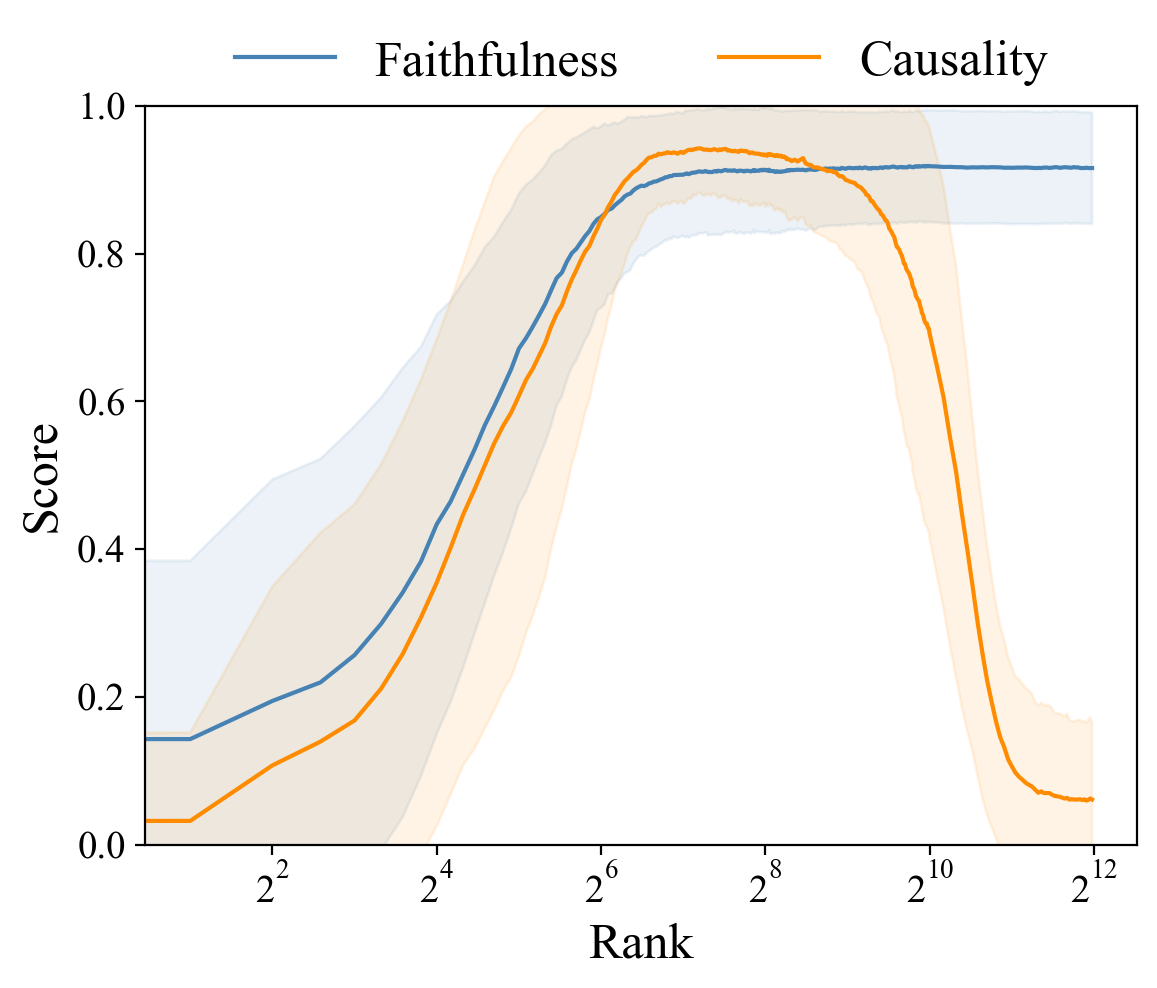

In [16]:
# plt.rcdefaults()
# fig_dir = "figs"
# #####################################################################################
# plt.rcdefaults()
# plt.rcParams["figure.dpi"] = 200
# plt.rcParams["font.family"] = "Times New Roman"

# SMALL_SIZE = 14
# MEDIUM_SIZE = 18
# BIGGER_SIZE = 22

# plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
# plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
# plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
# plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
# plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
# plt.rc("figure", titlesize=50)  # fontsize of the figure title


# faith_color = "steelblue"
# cause_color = "darkorange"
# #####################################################################################

# plt.plot(ranks, f_mean, label = "Faithfulness", color = faith_color, linewidth = 1.5)
# plt.fill_between(ranks, f_mean - f_std, f_mean + f_std, alpha = 0.1, color = faith_color)
# plt.plot(ranks, c_mean, label = "Causality", color = cause_color, linewidth = 1.5)
# plt.fill_between(ranks, c_mean - c_std, c_mean + c_std, alpha = 0.1, color = cause_color)

# plt.xscale("log", base = 2)
# plt.xlabel("Rank")
# plt.ylim(0, 1)
# plt.ylabel("Score")
# plt.legend(ncol = 2, bbox_to_anchor=(0.5, 1.15), loc='upper center', frameon=False)

# plt.savefig(f"{fig_dir}/rank-sweep.pdf", bbox_inches="tight")
# plt.show()

In [10]:
import pandas as pd

In [11]:
df = pd.read_csv("../../results/tables/gptj-beta-R.csv")
print(df.to_latex( index=False, float_format="%.2f" ))

\begin{tabular}{rllr}
\toprule
 beta & recall\_mean & efficacy\_mean &    R \\
\midrule
 0.00 & 0.17 ± 0.20 &   0.81 ± 0.22 & 0.30 \\
 0.25 & 0.21 ± 0.22 &   0.81 ± 0.22 & 0.33 \\
 0.50 & 0.28 ± 0.24 &   0.81 ± 0.22 & 0.38 \\
 0.75 & 0.36 ± 0.25 &   0.81 ± 0.22 & 0.48 \\
 1.00 & 0.43 ± 0.26 &   0.81 ± 0.22 & 0.58 \\
 1.25 & 0.50 ± 0.26 &   0.81 ± 0.22 & 0.67 \\
 1.50 & 0.54 ± 0.25 &   0.81 ± 0.22 & 0.76 \\
 1.75 & 0.57 ± 0.25 &   0.81 ± 0.22 & 0.80 \\
 2.00 & 0.59 ± 0.25 &   0.81 ± 0.22 & 0.83 \\
 2.25 & 0.59 ± 0.25 &   0.81 ± 0.22 & 0.84 \\
 2.50 & 0.59 ± 0.25 &   0.81 ± 0.22 & 0.84 \\
 2.75 & 0.59 ± 0.25 &   0.81 ± 0.22 & 0.84 \\
 3.00 & 0.59 ± 0.25 &   0.81 ± 0.22 & 0.83 \\
 3.25 & 0.58 ± 0.25 &   0.81 ± 0.22 & 0.81 \\
 3.50 & 0.57 ± 0.25 &   0.81 ± 0.22 & 0.80 \\
 3.75 & 0.56 ± 0.25 &   0.81 ± 0.22 & 0.78 \\
 4.00 & 0.55 ± 0.25 &   0.81 ± 0.22 & 0.76 \\
 4.25 & 0.54 ± 0.25 &   0.81 ± 0.22 & 0.75 \\
 4.50 & 0.53 ± 0.25 &   0.81 ± 0.22 & 0.74 \\
 4.75 & 0.53 ± 0.25 &   0.81 ± 0.22 & 

/tmp/ipykernel_1023229/3628729607.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex( index=False, float_format="%.2f" ))


In [12]:
df = pd.read_csv("../../results/tables/gptj-hparams.csv")
print(df.to_latex( index=False, float_format="%.2f" ))

\begin{tabular}{lrlllll}
\toprule
                  relation &  n\_range & layer &          beta &     rank &      recall@1 &      efficacy \\
\midrule
         adjective antonym &       95 &     8 &  2.25 ±  0.00 & 243 ± 57 &  0.69 ±  0.07 &  0.86 ±  0.04 \\
     adjective comparative &       57 &    10 &  2.25 ±  0.00 & 121 ± 31 &  0.98 ±  0.01 &  0.94 ±  0.04 \\
     adjective superlative &       79 &    10 &  2.25 ±  0.00 & 143 ± 48 &  0.93 ±  0.02 &  0.99 ±  0.01 \\
     characteristic gender &        2 &     1 &  2.25 ±  0.00 &  74 ± 70 &  0.77 ±  0.11 &  0.97 ±  0.04 \\
           city in country &       21 &     2 &  2.25 ±  0.00 & 115 ± 58 &  0.44 ±  0.10 &  0.89 ±  0.09 \\
               company CEO &      287 &     6 &  2.25 ±  0.00 & 173 ± 57 &  0.06 ±  0.03 &  0.31 ±  0.05 \\
                company hq &      163 &     6 &  2.25 ±  0.00 & 126 ± 25 &  0.21 ±  0.06 &  0.49 ±  0.04 \\
      country capital city &       24 &     3 &  2.25 ±  0.00 &  68 ± 43 &  0.88 ±  0.07 &  

/tmp/ipykernel_1023229/2347309347.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex( index=False, float_format="%.2f" ))


In [13]:
count = 0
for idx, row in df.iterrows():
    faith = float(row['recall@1'].split()[0])
    count += faith > 0.6
count/len(df)

0.4782608695652174